In [1]:
from matplotlib import pyplot as plt
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix 
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import model_from_json
from keras.utils import multi_gpu_model 
from keras.utils import to_categorical


Using TensorFlow backend.


Read the data
===========

In [2]:
x_original=pd.read_csv('../_xlable4_withNa_AllColumns.txt')
y_original=pd.read_csv('../_targelable4_withNa_AllColumns.txt')


# x_original=x_original[['Unnamed: 0','S000501','S000502','S000300','SEX','L190300','L190400','L190500','L100700','L103300',
# 'L100500','S000100','L100800','L103000','L101700','L101300','FIELD_33','L101600','FIELD_38','AGE' 
#                       ]]

y_original=y_original[['Unnamed: 0','S000501']]

print(x_original.shape)
print(y_original.shape)


(159381, 408)
(159381, 2)


Prepare the data
============

In [3]:
data= pd.merge(x_original,y_original, how='inner',left_on='Unnamed: 0', right_on='Unnamed: 0')

condtion = [
    data.FIELD_38 == 0,
    (data.FIELD_38 > 0) & (data.FIELD_38 < 4),
    data.FIELD_38 >= 4,
]
choice = [0, 1, 2]
data["FIELD_38_C"] = np.select(condtion, choice, default=np.nan)
print(data.shape)


(159381, 410)


In [4]:
# filter the data set
data = data[data.FIELD_16 != 1]  # exclude people who are diagnosed for (diabetes)
data = data[data.FIELD_23 != 1]  # exclude people who are on medication for diabetes

data = data[
    data.FIELD_15 != 1
]  # exclude people who are diagnosed for (high blood pressure)
data = data[
    data.FIELD_22 != 1
]  # exclude people who are on medication for high blood pressure

data = data[data.FIELD_17 != 1]  # exclude people who are diagnosed for hyperlipidemia
data = data[
    data.FIELD_24 != 1
]  # exclude people who are on medication for hyperlipidemia

data = data[data.FIELD_13 != 1]  
data = data[data.FIELD_20 != 1]  

print(data.shape)

(159174, 410)


In [5]:
data["max"] = np.min(data[["FIELD_6", "FIELD_7"]], axis=1)
data = data.drop(columns=["FIELD_6", "FIELD_7"])

print(data.shape)
data=data[['S000501_y','S000501_x', 'S000300', 'S000502', 'L103000', 'L100800', 'L103100',
       'L100700',  'L101300', 'L190500', 'L190300', 'L103300',
       'L190400', 'L101700', 'L101600',
        "FIELD_38","FIELD_33","FIELD_41","FIELD_42",
          ]].dropna().reset_index()
data.head()

(159174, 409)


,index,S000501_y,S000501_x,S000300,S000502,L103000,L100800,L103100,L100700,L101300,L190500,L190300,L103300,L190400,L101700,L101600,FIELD_38,FIELD_33,FIELD_41,FIELD_42
0,0,117.0,121.0,20.1,67.0,53.0,77.0,68.0,3.0,8.0,38.2,4.20,3.1,12.3,13.0,49.0,1.0,1.0,2.0,4.0
1,1,135.0,117.0,19.7,76.0,53.0,89.0,71.0,3.0,9.0,39.0,4.24,3.3,13.1,14.0,51.0,1.0,1.0,3.0,4.0
2,2,129.0,135.0,20.2,82.0,41.0,78.0,72.0,3.8,10.0,38.4,4.26,3.4,12.9,15.0,56.0,2.0,1.0,2.0,3.0
3,3,111.0,118.0,24.8,71.0,58.0,95.0,64.0,3.7,12.0,40.3,4.20,2.8,13.5,10.0,42.0,0.0,1.0,3.0,0.0
4,4,122.0,111.0,25.5,65.0,50.0,90.0,58.0,3.4,12.0,38.6,3.92,2.9,12.6,12.0,46.0,0.0,1.0,3.0,1.0


In [6]:
x=data[['S000501_x', 'S000300', 'S000502', 'L103000', 'L100800', 'L103100',
       'L100700',  'L101300', 'L190500', 'L190300', 'L103300',
       'L190400', 'L101700', 'L101600',
#         "FIELD_38","FIELD_33","FIELD_41","FIELD_42"
       ]]

y=data[['S000501_y']]

Check the correlation of the selected feature with the independent variables
=====

In [7]:
temppd=pd.DataFrame(x.copy())
temppd['y']=y.S000501_y
temppd.head()
corval=abs(temppd.corr()).sort_values(by='y', ascending=False)

In [8]:
corval.y

y            1.000000
S000501_x    0.665464
S000502      0.571263
S000300      0.444929
L190300      0.353216
L190400      0.351912
L190500      0.346154
L100700      0.341989
L103300      0.287325
L100800      0.264217
L103000      0.261239
L101700      0.247042
L101300      0.238877
L103100      0.219454
L101600      0.197345
Name: y, dtype: float64

In [9]:
#histogram plot of the features
# import matplotlib.pyplot as plt
# x[x.dtypes[(x.dtypes=="float64")|(x.dtypes=="int64")]
#                         .index.values].hist(figsize=[11,11])

Apply PCA
===========

In [10]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=8)
# pca.fit(x)

# print(pca.explained_variance_ratio_)   
# print(np.sum(pca.explained_variance_ratio_))

# x=pca.fit_transform(x) 
# print(x.shape)


feature scaling
=======

In [11]:
# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()  #StandardScaler()
# x = min_max_scaler.fit_transform(x)

clustring test
==========

In [12]:
# from sklearn.cluster import KMeans
# from scipy.spatial.distance import cdist

# K = range(1,10)
# distortions = []

# for k in K:
#     kmeanModel = KMeans(n_clusters=k).fit(x)
#     kmeanModel.fit(x)
#     distortions.append(sum(np.min(cdist(x, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / x.shape[0])

# # Plot the elbow
# plt.plot(K, distortions, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method showing the optimal k')
# plt.show()


In [13]:
# kmeanModel = KMeans(n_clusters=k).fit(x)
# x['lbl']=kmeanModel.labels_ 

In [15]:
# print(ytrain.shape)
# print(ytest.shape)

Random Forest Regressor
=============

In [16]:
ylable=y[['S000501_y']]  
xtrain,xtest,ytrain,ytest=train_test_split(x, ylable, random_state=42, test_size=0.2)

In [17]:
regr = RandomForestRegressor(max_depth=7, random_state=0,verbose =0,n_estimators=500)
regr.fit(xtrain, ytrain) 
print(regr.feature_importances_)
ypred=regr.predict(xtest)


[8.82492549e-01 6.16099809e-02 2.05874670e-02 1.02426058e-03
 1.55561989e-03 7.18492928e-04 4.53021714e-03 1.24642772e-03
 3.78340178e-03 3.74541513e-03 6.77571245e-04 1.21319098e-02
 4.78767537e-03 1.10901114e-03]


mean_squared_error 81.02005971035939
root mean_squared_error 9.001114359364589
mean_absolute_error 7.1557602423600954
r2_score 0.488276826062814


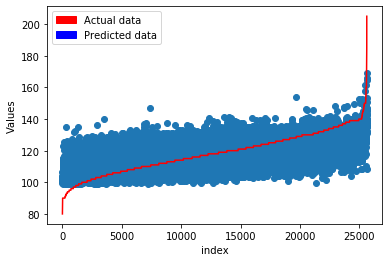

,t + 1,pred (t +1)
802,171.0,139.577404
24189,172.0,135.160998
3462,174.0,150.853992
21273,177.0,147.173735
24595,180.0,131.252937
25134,180.0,132.409594
798,180.0,166.152620
23267,185.0,135.664511
16470,204.0,153.236446
25302,205.0,168.835696


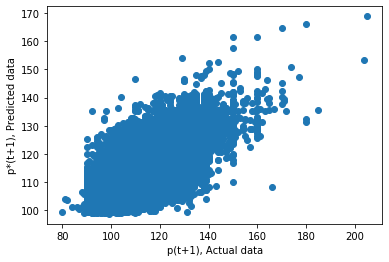

In [18]:

import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(30)

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

ypredPD.tail(10)

In [19]:
ypredPD["diff"] = abs(ypredPD["t + 1"] - ypredPD["pred (t +1)"])
print("|Actual - predicted < 5 mmHg|", "{:.1f}%".format(100 * ypredPD[ypredPD["diff"] < 5].shape[0] / ypredPD.shape[0]))
print("|Actual - predicted < 10 mmHg|", "{:.1f}%".format(100 * ypredPD[ypredPD["diff"] < 10].shape[0] / ypredPD.shape[0]))
print("|Actual - predicted < 15 mmHg|", "{:.1f}%".format(100 * ypredPD[ypredPD["diff"] < 15].shape[0] / ypredPD.shape[0]))
print("|Actual - predicted < 20 mmHg|", "{:.1f}%".format(100 * ypredPD[ypredPD["diff"] < 20].shape[0] / ypredPD.shape[0]))
print("|Actual - predicted < 25 mmHg|", "{:.1f}%".format(100 * ypredPD[ypredPD["diff"] < 25].shape[0] / ypredPD.shape[0]))
print("|Actual - predicted < 30 mmHg|", "{:.1f}%".format(100 * ypredPD[ypredPD["diff"] < 30].shape[0] / ypredPD.shape[0]))

|Actual - predicted < 5 mmHg| 42.2%
|Actual - predicted < 10 mmHg| 73.8%
|Actual - predicted < 15 mmHg| 90.8%
|Actual - predicted < 20 mmHg| 97.3%
|Actual - predicted < 25 mmHg| 99.3%
|Actual - predicted < 30 mmHg| 99.8%


xg boost
==========

In [20]:
import xgboost as xgb
# from sklearn.metrics import mean_squared_error
# import pandas as pd
# import numpy as np

In [21]:
xg_reg = xgb.XGBRegressor()
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, 
#                           learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(xtrain, ytrain) 

[00:12:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

mean_squared_error 80.2351969697799
root mean_squared_error 8.957410170902072
mean_absolute_error 7.117679076586516
r2_score 0.49323402375126524


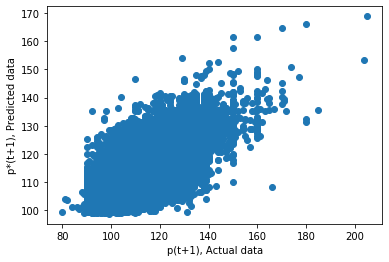

In [22]:

ypred = xg_reg.predict(xtest)

import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

# ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
# ypredPD['t + 1']=ytest.values
# ypredPD['pred (t +1)']=ypred
# ypredPD.head(10)

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])


In [23]:
ypredPD["diff"] = abs(ypredPD["t + 1"] - ypredPD["pred (t +1)"])
print("|Actual - predicted < 5 mmHg|", "{:.1f}%".format(100 * ypredPD[ypredPD["diff"] < 5].shape[0] / ypredPD.shape[0]))
print("|Actual - predicted < 10 mmHg|", "{:.1f}%".format(100 * ypredPD[ypredPD["diff"] < 10].shape[0] / ypredPD.shape[0]))
print("|Actual - predicted < 15 mmHg|", "{:.1f}%".format(100 * ypredPD[ypredPD["diff"] < 15].shape[0] / ypredPD.shape[0]))
print("|Actual - predicted < 20 mmHg|", "{:.1f}%".format(100 * ypredPD[ypredPD["diff"] < 20].shape[0] / ypredPD.shape[0]))
print("|Actual - predicted < 25 mmHg|", "{:.1f}%".format(100 * ypredPD[ypredPD["diff"] < 25].shape[0] / ypredPD.shape[0]))
print("|Actual - predicted < 30 mmHg|", "{:.1f}%".format(100 * ypredPD[ypredPD["diff"] < 30].shape[0] / ypredPD.shape[0]))

|Actual - predicted < 5 mmHg| 42.2%
|Actual - predicted < 10 mmHg| 73.8%
|Actual - predicted < 15 mmHg| 90.8%
|Actual - predicted < 20 mmHg| 97.3%
|Actual - predicted < 25 mmHg| 99.3%
|Actual - predicted < 30 mmHg| 99.8%


ANN
==========

In [ ]:
model= Sequential()
model.add(Dense(input_dim=29,units=128,activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=128, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=64, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=32, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=16, activation='relu', kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=8, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=1, kernel_initializer='uniform'))
model.compile(loss='mean_squared_error', optimizer='Nadam', metrics=['mean_squared_error' ])

In [ ]:
h=model.fit(xtrain, ytrain, validation_split=.2,epochs=100, batch_size=50)

In [ ]:
ypred=model.predict(xtest)

import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)

In [ ]:
history=h
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['val_mean_squared_error'])
plt.plot(history.history['mean_squared_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
ypredPD['diff']=abs(ypredPD['t + 1']- ypredPD['pred (t +1)'])
print(np.mean(ypredPD['diff']))
print(np.std(ypredPD['diff']))
print(100*ypredPD[ypredPD['diff']<=5].shape[0]/ypredPD.shape[0])

In [ ]:

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

ypredPD.head(10)

SVR
======

In [ ]:
from sklearn.svm import SVR
# svr_rbf = SVR(kernel='rbf', C=10, gamma=0.02, epsilon=.001)
svr_rbf = SVR(kernel='rbf')

In [ ]:
svr_rbf.fit(xtrain, ytrain) 

In [ ]:
ypred=svr_rbf.predict(xtest)

In [ ]:
import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)